In [ ]:
# pip install -qq -U tensorflow-addons
!pip install einops

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import random
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from PIL import Image, ImageEnhance, ImageFilter
#vit libraries
import torch
from torch import Tensor
from torch import nn
import torch.optim as optim
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import ConcatDataset,Dataset
from torchvision.transforms import Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange
from PIL import Image


In [ ]:
TBI_folder = '/content/drive/MyDrive/TBI_FINAL_IMAGES/'
NONTBI_folder = '/content/drive/MyDrive/NONTBI_FINAL_IMAGES/'
TBI_folder_augmented = '/content/drive/MyDrive/TBI_FINAL_IMAGES/augmented/'
NONTBI_folder_augmented = '/content/drive/MyDrive/NONTBI_FINAL_IMAGES/augmented/'
TBI_files_names = os.listdir(TBI_folder)
TBI_aug_files_names = os.listdir(TBI_folder_augmented)
NONTBI_files_names = os.listdir(NONTBI_folder)
NONTBI_aug_files_names = os.listdir(NONTBI_folder_augmented)



# Print or use the arrays as needed
print("TBI Files:",len(TBI_files_names))
print("NON_TBI Files:", len(NONTBI_files_names))
print("TBI Files:",len(TBI_aug_files_names))
print("NON_TBI Files:", len(NONTBI_aug_files_names))
# Check if CUDA is available
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Device:", device)

TBI Files: 249
NON_TBI Files: 243
TBI Files: 2232
NON_TBI Files: 2178
Device: cpu


In [ ]:
class LazySignatureDataset(Dataset):
    def __init__(self, file_paths, class_label, transform=None):
        self.file_paths = file_paths
        self.class_label = class_label
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        img_path = self.file_paths[index]
        label = self.class_label

        # Load image only when needed
        image = Image.open(img_path).convert("RGB")

        if self.transform and img_path.endswith('.png'):
            image = self.transform(image)

        return image, label
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        return image
to_tensor = [Resize((224, 224)),ToTensor()]
transform = Compose(to_tensor)

# Use specific files from forgery_files and real_files
forgery_files = [TBI_folder + file for file in TBI_files_names]
forgery_aug_files = [TBI_folder_augmented + file for file in TBI_aug_files_names]
real_files = [NONTBI_folder + file for file in NONTBI_files_names]
real_aug_files = [NONTBI_folder_augmented + file for file in NONTBI_aug_files_names]
print(len(forgery_files))
print(len(forgery_aug_files))
print(len(real_files))
print(len(real_aug_files))
def filter_png_files(file_paths):
    return [file_path for file_path in file_paths if file_path.endswith('.png')]

forgery_png_files = filter_png_files(forgery_files)
forgery_aug_png_files = filter_png_files(forgery_aug_files)
real_png_files = filter_png_files(real_files)
real_aug_png_files = filter_png_files(real_aug_files)

# Create instances of the LazySignatureDataset with filtered PNG files
dataset_forg = LazySignatureDataset(forgery_png_files, class_label=0, transform=transform)
dataset_aug_forg = LazySignatureDataset(forgery_aug_png_files, class_label=0, transform=transform)
dataset_org = LazySignatureDataset(real_png_files, class_label=1, transform=transform)
dataset_aug_org = LazySignatureDataset(real_aug_png_files, class_label=1, transform=transform)

249
2232
243
2178


In [ ]:
combined_dataset = ConcatDataset([dataset_forg,dataset_aug_forg,dataset_org,dataset_aug_org])
print(len(combined_dataset))

4900


Forgery Images:


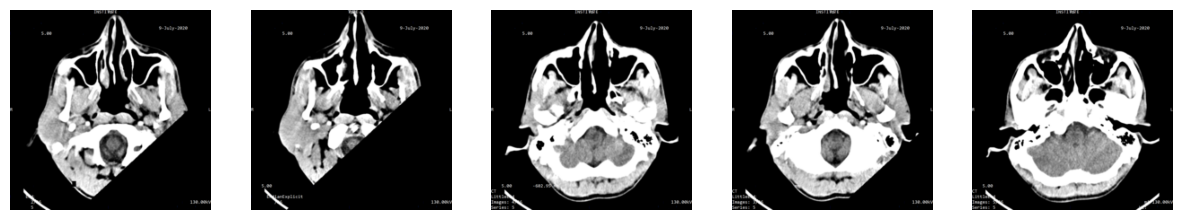

Forgery Augmented Images:


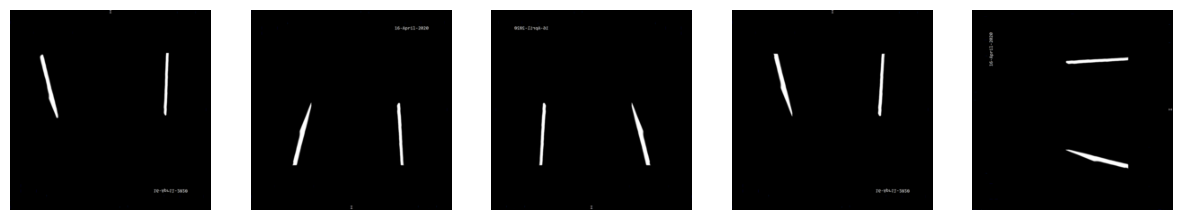

Original Images:


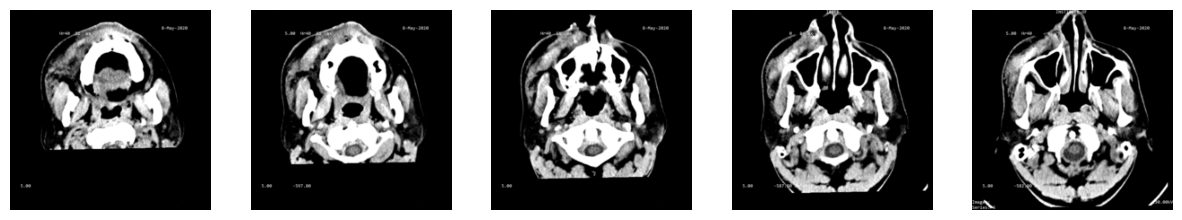

Original Augmented Images:


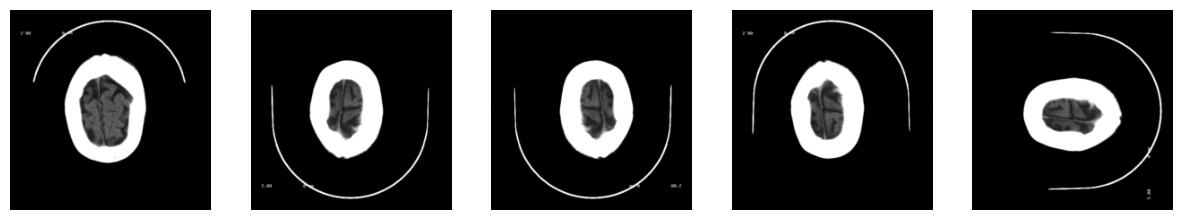

In [ ]:
import matplotlib.pyplot as plt

# Define a function to display images
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, _ = dataset[i]  # Retrieve image and label
        axes[i].imshow(image.permute(1, 2, 0))  # Permute dimensions for visualization
        axes[i].axis('off')
    plt.show()

# Print 5 images from the forgery dataset
print("Forgery Images:")
show_images(dataset_forg)
print("Forgery Augmented Images:")
show_images(dataset_aug_forg)

# Print 5 images from the original dataset
print("Original Images:")
show_images(dataset_org)
print("Original Augmented Images:")
show_images(dataset_aug_org)


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 16, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
class ViT(nn.Module):
    def __init__(self, ch=3, img_size=224, patch_size=16, emb_dim=128,
                n_layers=6, out_dim=2, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])

    def extract_features(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Global Average Pooling
        features = x.mean(dim=1, keepdim=True)

        return features.squeeze()


In [ ]:
model = ViT().to('cpu')

In [ ]:
def extract_features(dataloader, model,bin):
    features = []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in dataloader:
            # Forward pass through the ViT model
            sample_datapoint = torch.unsqueeze(images,bin)
            outputs = model.extract_features(sample_datapoint)
            features.append(outputs.numpy())  # Assuming outputs is a PyTorch tensor
    return features

# Extract features for both forgery and genuine datasets

start_time = time.time()
forgery_features = extract_features(dataset_forg, model,0)
forgery_aug_features = extract_features(dataset_aug_forg, model,0)

genuine_features = extract_features(dataset_org, model,0)
genuine_aug_features = extract_features(dataset_aug_org, model,0)

end_time = time.time()

In [ ]:
extract_features_time = end_time - start_time
print("Time taken:", extract_features_time, "seconds")

Time taken: 2314.93431019783 seconds


In [ ]:
print(len(forgery_features)," ",len(genuine_features)," ",len(forgery_aug_features)," ",len(genuine_aug_features))
print(forgery_features[1])

248   242   2232   2178
[ 0.22388852  0.36018744  0.46317926 -0.02326668  0.30920592  0.52003056
  0.18919119  0.55041623 -0.48495921  0.24443576 -0.08607039  0.22787693
  0.11255205  0.02838363 -0.2822204  -0.5082866  -0.50025094  0.18413763
  0.13487223 -0.3548314  -0.33584568 -0.42758465 -0.29202428 -0.36127424
 -0.1499191  -0.3287454  -0.6248834   0.13328151  0.00548251  0.17917922
 -0.18568124 -0.22913069  0.46193725  0.49998307 -0.2116473   0.0192685
 -0.00808081  0.2695341   0.35228184 -0.11540601  0.17607109 -0.23906441
 -0.10091007 -0.13707231 -0.2736665   0.18060601 -0.5229877  -0.02150671
 -0.1894587   0.03906458 -0.62122244 -0.17402247  0.15960506 -0.6464083
 -0.45527607 -0.25262812 -0.09504746  0.24468017 -0.25139642 -0.17349258
  0.47465175  0.12300245 -0.38455707  0.46408233 -0.04755048  0.10651298
  0.3929518  -0.19417219 -0.01148266 -0.4854038   0.3194561   0.55872643
 -0.02585343 -0.555556   -0.01665292 -0.41921726 -0.43621835 -0.11182122
  0.28761446  0.12900765  0.0

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/final_augmented_glcm_features.csv')

In [ ]:
print(df.head())

     Contrast  Correlation    Energy  Homogeneity  Class
0  137.103207     0.992168  0.669285     0.791825      1
1  128.467792     0.990856  0.757951     0.842589      1
2  172.905438     0.992302  0.612433     0.797752      1
3  156.216283     0.992789  0.618474     0.792959      1
4  177.997572     0.992113  0.609684     0.804831      1


In [ ]:
print(df.shape)

(4900, 5)


In [ ]:
df['Class']=1-df['Class']

In [ ]:
print(df.shape)

(4900, 5)


In [ ]:
vitff=[]
for features in forgery_features:
    vitff.append(features)
for features in forgery_aug_features:
    vitff.append(features)
for features in genuine_features:
    vitff.append(features)
for features in genuine_aug_features:
    vitff.append(features)
print(len(vitff))

4900


In [ ]:
df['vitf']=vitff

In [ ]:
df.columns

Index(['Contrast', 'Correlation', 'Energy', 'Homogeneity', 'Class', 'vitf'], dtype='object')

In [ ]:
df.to_csv('final_mri_features.csv', index=False)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/final_mri_features.csv')

In [ ]:
print(df.shape)

(4900, 6)


In [ ]:
# Assuming 'data' is your DataFrame
print("Data Types of Each Column:")
print(df.dtypes)

Data Types of Each Column:
Contrast       float64
Correlation    float64
Energy         float64
Homogeneity    float64
Class            int64
vitf            object
dtype: object


In [ ]:
import ast
df['vitf'] = df['vitf'].apply(ast.literal_eval)

In [ ]:
import numpy as np

df['vitf'] = df['vitf'].apply(lambda x: np.array(x))

# Now 'vitf' column should contain NumPy arrays
print(df['vitf'].head())

0    [0.26739487, 0.33337623, 0.44089445, -0.015376...
1    [0.22388852, 0.36018744, 0.46317926, -0.023266...
2    [0.33407563, 0.29519138, 0.46654615, -0.076937...
3    [0.3182723, 0.31159, 0.4572251, -0.060869053, ...
4    [0.3441805, 0.30103123, 0.4397318, -0.08229954...
Name: vitf, dtype: object


In [ ]:
# # Concatenate the 'vitf' lists with the original DataFrame
X = np.vstack(df['vitf'].values)
X = np.hstack([df.drop(columns=['Class', 'vitf']).values, X])

In [ ]:
y=df['Class']

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Random undersampling to balance the dataset
# rus = RandomUnderSampler(random_state=42)
# X_ur, y_ur = rus.fit_resample(X, y)

# # Random oversampling to balance the dataset
ros = RandomOverSampler(random_state=42)
X_ur, y_ur = ros.fit_resample(X, y)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
print(len(X_train)," ",len(X_test))
print(X_train.shape)

3920   980
(3920, 132)


In [83]:
from sklearn import preprocessing
max_abs_scaler = preprocessing.MinMaxScaler()
X_train_maxabs = max_abs_scaler.fit_transform(X_train)
X_test_maxabs = max_abs_scaler.transform(X_test)

In [84]:
X_maxabs=max_abs_scaler.fit_transform(X)

In [85]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42,oob_score=True)

# Train the classifier on the training data
rf_st=time.time()
rf_classifier.fit(X_train_maxabs, y_train)
rf_et=time.time()
print("random forest training time: ", rf_et-rf_st)

# Predict labels for the test set
y_pred = rf_classifier.predict(X_test_maxabs)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
oob_error = 1 - rf_classifier.oob_score_

random forest training time:  36.163429737091064
Accuracy: 0.9693877551020408


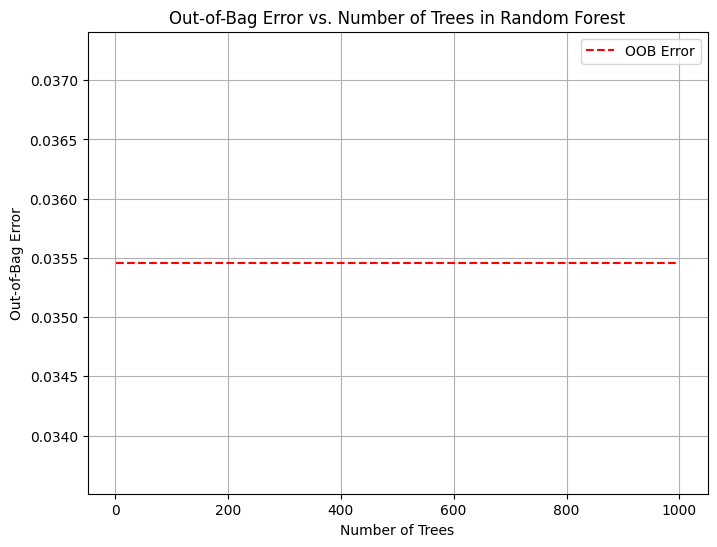

In [65]:
plt.figure(figsize=(8, 6))
plt.plot([1, 1000], [oob_error, oob_error], 'r--', label='OOB Error')
plt.xlabel('Number of Trees')
plt.ylabel('Out-of-Bag Error')
plt.title('Out-of-Bag Error vs. Number of Trees in Random Forest')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/1000
123/123 [==============================] - 2s 5ms/step - loss: 0.6504 - accuracy: 0.6161 - val_loss: 0.6194 - val_accuracy: 0.6520
Epoch 2/1000
123/123 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6408 - val_loss: 0.6115 - val_accuracy: 0.6653
Epoch 3/1000
123/123 [==============================] - 0s 3ms/step - loss: 0.6193 - accuracy: 0.6574 - val_loss: 0.6129 - val_accuracy: 0.6704
Epoch 4/1000
123/123 [==============================] - 0s 3ms/step - loss: 0.5941 - accuracy: 0.6791 - val_loss: 0.5865 - val_accuracy: 0.6837
Epoch 5/1000
123/123 [==============================] - 0s 3ms/step - loss: 0.5920 - accuracy: 0.6852 - val_loss: 0.5638 - val_accuracy: 0.7020
Epoch 6/1000
123/123 [==============================] - 0s 3ms/step - loss: 0.5741 - accuracy: 0.6969 - val_loss: 0.5532 - val_accuracy: 0.7133
Epoch 7/1000
123/123 [==============================] - 0s 3ms/step - loss: 0.5606 - accuracy: 0.7023 - val_loss: 0.5553 - val_accuracy:

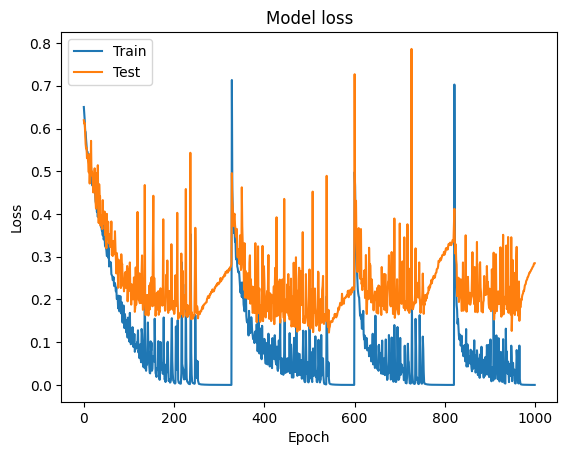

In [91]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.callbacks import History

# Initialize the Keras model
model = Sequential()
model.add(Dense(128, input_dim=X_train_maxabs.shape[1], activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Train the model and record the history
history = History()
mlp_st = time.time()
model.fit(X_train_maxabs, y_train, epochs=1000, batch_size=32, verbose=1, callbacks=[history], validation_data=(X_test_maxabs, y_test))
mlp_et = time.time()
print("MLP training time: ", mlp_et - mlp_st)

# Predict labels for the test set
y_pred_probs = model.predict(X_test_maxabs)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred.flatten())
# print(y_pred)
print("Accuracy:", accuracy)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
# Initialize the MLPClassifier with important hyperparameters
mlp = MLPClassifier(
    hidden_layer_sizes=(128,64,32,16),  # You can set the number of neurons in hidden layers here
    activation='tanh',  # Activation function for hidden layers
    solver='adam',  # Optimization algorithm ('adam', 'sgd', etc.)
    alpha=0.0001,  # L2 penalty (regularization term) parameter
    max_iter=500,
    learning_rate='constant',  # Learning rate schedule ('constant', 'adaptive', 'invscaling')
    random_state=42,
    verbose=True,
    early_stopping=False,
    tol=1e-7

)

# Train the MLPClassifier on your data
mlp_st=time.time()
mlp.fit(X_train_maxabs, y_train)
mlp_et=time.time()
print("MLP training time: ",mlp_et-mlp_st)

# Predict labels for the test set
y_pred = mlp.predict(X_test_maxabs)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(y_pred)
print("Accuracy:", accuracy)


In [100]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.1)

# Fit the classifier
xgb_st=time.time()
xgb_classifier.fit(X_train_maxabs, y_train)
xgb_et=time.time()
print("xgb classifier training time: ", xgb_et-xgb_st)
# Predict labels for the test set
y_pred = xgb_classifier.predict(X_test_maxabs)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

xgb classifier training time:  11.762000560760498
Accuracy: 0.9744897959183674


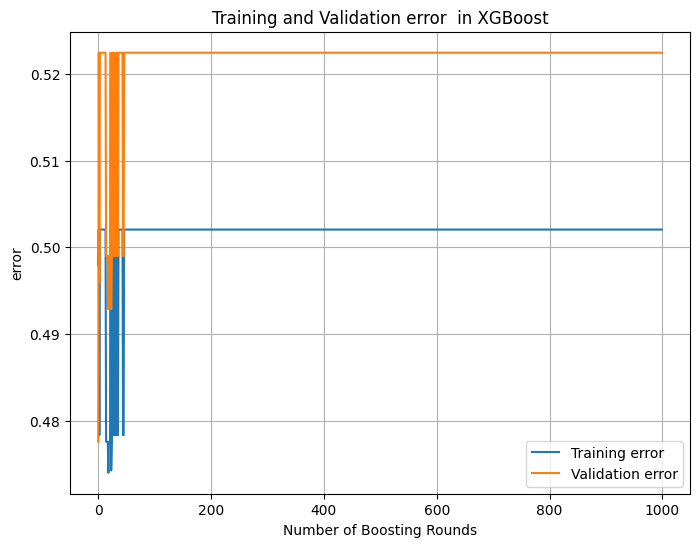

In [77]:
results = xgb_classifier.evals_result()

# Extract the training and validation log loss from the results
train_logloss = results['validation_0']['error']
val_logloss = results['validation_1']['error']

# Plot the training and validation log loss
plt.figure(figsize=(8, 6))
plt.plot(range(len(train_logloss)), train_logloss, label='Training error')
plt.plot(range(len(val_logloss)), val_logloss, label='Validation error')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('error')
plt.title('Training and Validation error  in XGBoost')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier(n_estimators=1000, random_state=42)

# Training the AdaBoost classifier
ada_st=time.time()
adaboost_clf.fit(X_train_maxabs, y_train)
ada_et=time.time()
print("adaboost training time: ",ada_et-ada_st)
# Making predictions on the testing set
y_pred = adaboost_clf.predict(X_test_maxabs)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

adaboost training time:  65.85791110992432
Accuracy: 0.9551020408163265


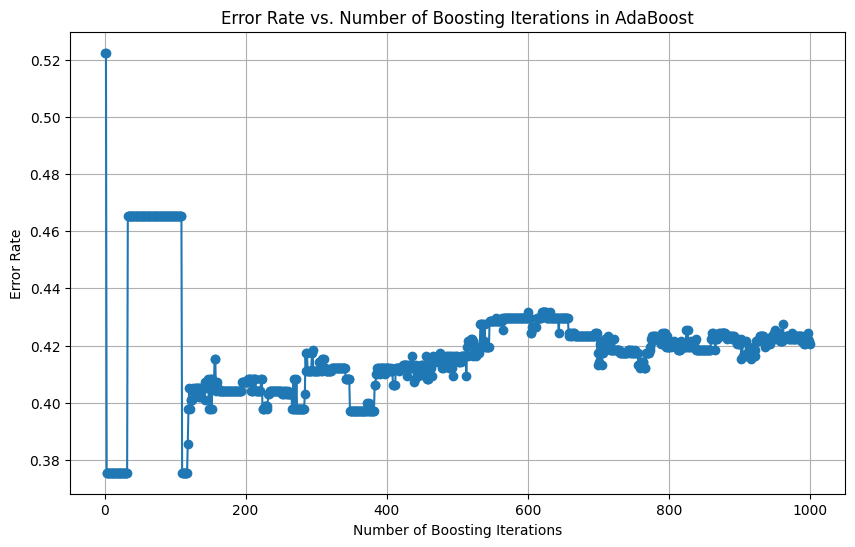

In [80]:
error_rate = np.zeros((1000,))
for i, y_pred in enumerate(adaboost_clf.staged_predict(X_test)):
    error_rate[i] = 1 - accuracy_score(y_test, y_pred)

# Plot the error rate
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(error_rate) + 1), error_rate, marker='o', linestyle='-')
plt.xlabel('Number of Boosting Iterations')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Boosting Iterations in AdaBoost')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
k = 3  # Number of folds
cv_scores = cross_val_score(xgb_classifier, X, y, cv=k)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean and standard deviation of the cross-validation scores
print("Mean accuracy:", np.mean(cv_scores))
print("Standard deviation of accuracy:", np.std(cv_scores))

Cross-validation scores: [0.79804162 0.64849969 0.77954685]
Mean accuracy: 0.7420293852591003
Standard deviation of accuracy: 0.06656508849611036


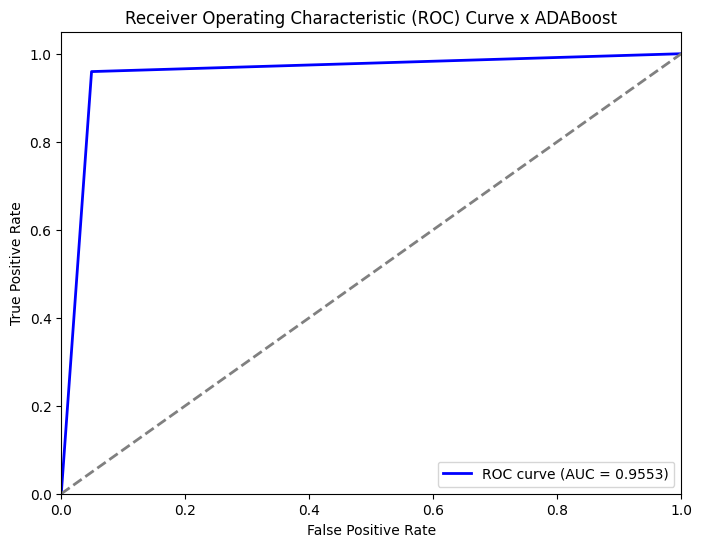

In [97]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute AUC score
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve x ADABoost')
plt.legend(loc='lower right')
plt.show()

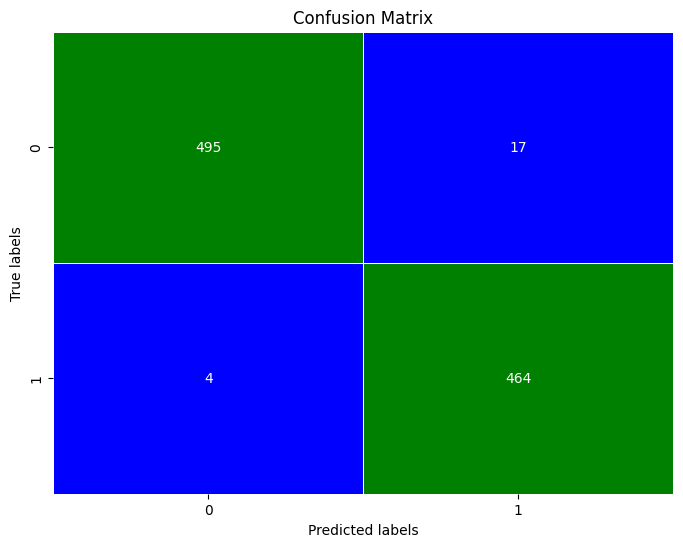

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are the true labels and predicted labels, respectively
# y_test: True labels
# y_pred: Predicted labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define colors for each metric
colors = ['blue', 'orange', 'red', 'green']  # TN, FP, FN, TP


# Create colormap
cmap = sns.color_palette(colors)

# Plot confusion matrix with customized colors
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap, cbar=False, linewidths=0.5)

# Add legend
for i, label in enumerate(labels):
    plt.plot([], [], color=colors[i], label=label)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")


plt.show()


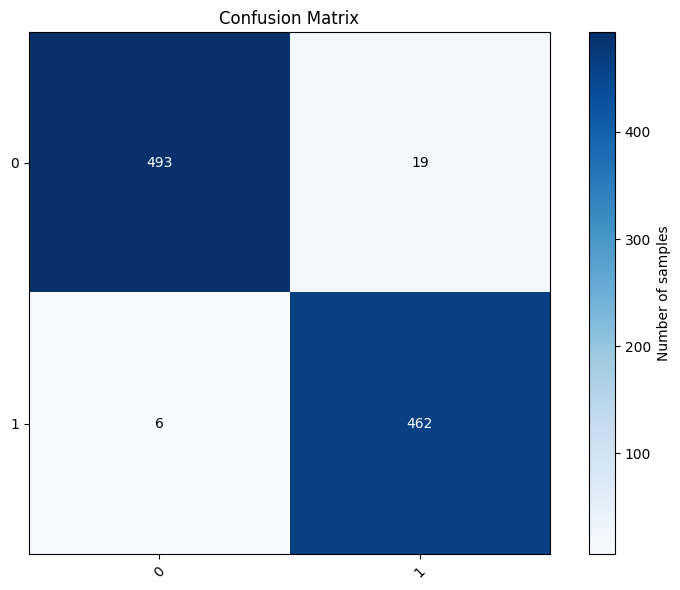

In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have y_test and y_pred from your classification model

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a new figure for the plot
plt.figure(figsize=(8, 6))

# Plot the confusion matrix as a heatmap
plt.imshow(cm, interpolation='nearest', cmap='Blues')  # Adjust 'Blues' for desired colormap

# Add labels and title
plt.colorbar(label='Number of samples')
classes = [str(x) for x in range(len(cm))]  # Assuming class labels are numerical (adjust if needed)
plt.xticks(range(len(classes)), classes, rotation=45)
plt.yticks(range(len(classes)), classes)
plt.title('Confusion Matrix')

# Add text labels to each cell (optional)
fmt = 'd'  # Adjust format string for counts as needed
thresh = cm.max() / 2.  # Threshold for text color
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.tight_layout()
plt.show()

In [110]:
from sklearn.metrics import f1_score

# Assuming y_test contains the true labels and y_pred contains the predicted labels
# y_test: True labels
# y_pred: Predicted labels

# Compute F1 score
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)


F1 Score: 0.9736564805057956


In [106]:
# Assuming y_test contains the true labels and y_pred contains the predicted labels
# y_test: True labels (1 for positive cases, 0 for negative cases)
# y_pred: Predicted labels

# Calculate false positives
false_positives = sum((y_test == 0) & (y_pred == 1))

print("Number of False Positives:", false_positives)


Number of False Positives: 19


In [107]:
# Assuming y_test contains the true labels and y_pred contains the predicted labels
# y_test: True labels (1 for positive cases, 0 for negative cases)
# y_pred: Predicted labels

# Calculate true positives
true_positives = sum((y_test == 1) & (y_pred == 1))

print("Number of True Positives:", true_positives)


Number of True Positives: 462


In [108]:
# Assuming y_test contains the true labels and y_pred contains the predicted labels
# y_test: True labels (1 for positive cases, 0 for negative cases)
# y_pred: Predicted labels

# Calculate false negatives
false_negatives = sum((y_test == 1) & (y_pred == 0))

print("Number of False Negatives:", false_negatives)

Number of False Negatives: 6


In [109]:
# Assuming y_test contains the true labels and y_pred contains the predicted labels
# y_test: True labels (1 for positive cases, 0 for negative cases)
# y_pred: Predicted labels

# Calculate true negatives
true_negatives = sum((y_test == 0) & (y_pred == 0))

print("Number of True Negatives:", true_negatives)


Number of True Negatives: 493


<Figure size 1000x600 with 0 Axes>

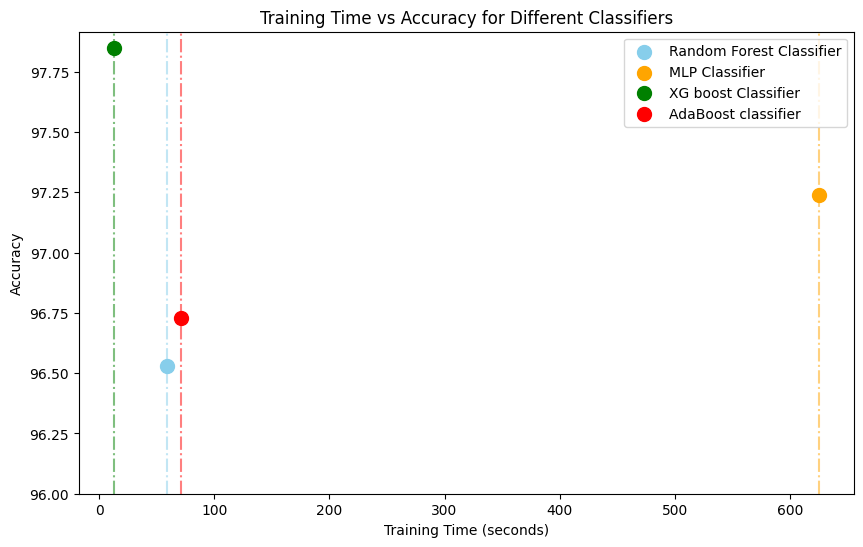

In [ ]:
import matplotlib.pyplot as plt

# Classifier names
classifiers = ['Random Forest Classifier', 'MLP Classifier', 'XG boost Classifier','AdaBoost classifier']

# Training times
training_times = [58.58922004699707,624.9886875152588,13.029915809631348,71.01077127456665]

# Accuracy scores
accuracy_scores = [96.53,97.24,97.85,96.73]  # Replace these values with your actual accuracy scores

# Create scatter plot
plt.figure(figsize=(10, 6))
colors = ['skyblue', 'orange', 'green', 'red']

# Create scatter plot
plt.figure(figsize=(10, 6))
for i in range(len(classifiers)):
    plt.scatter(training_times[i], accuracy_scores[i], color=colors[i], s=100, label=classifiers[i])
    plt.axvline(training_times[i], color=colors[i], linestyle='dashdot', alpha=0.5)
plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy')

plt.title('Training Time vs Accuracy for Different Classifiers')

# Set y-axis range starting from 96
plt.ylim(96, None)

# Add legend
plt.legend(loc='upper right')

plt.show()